# Feature Preprocessing

This notebook should take the output of the bioinformatics pipelines and do any preprocessing and reshaping to prepare the feature vectors for the prediction models

Currently this includes taking the TPM matrices and samples metedata tables and separating the single cell and bulk channels. 
The expression in the TPM matrix is given per gene so first the genomic positions of the genes are extracted from Ensmbl, this can be used to produce a BED like format: chr,start,end,tpm
We also take a similar BED like files defining the centromere locations and the target copy number profiles.

The fine_bin fuction can then process all these channels in the same way, by dividing the genome into bins of size ws and then distributing the value column of the BED file into the bins spanning the feature.
The overlap_reduce argument of fine_bin is a function that decides how to handle bins that contain multiple features. It has the signature 

new_bin_value = overlap_reduce(old_bin_value, features_in_bin, new_feature_value)

For example for the expression data which is of the form log2(TPM + 1) has

overlap_reduce = lambda x,n,y: np.log2(1 + (n*(2**x-1) + 2**y-1)/(n+1)

Which is to say the bin contains the log average TPM

\log((\Sigma_{genes}{TPM_i})/N_{genes} + 1)



In [41]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import os,re, glob
import pickle
import pandas as pd
import re,pyensembl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import itertools
import Bio.SeqIO, Bio.SeqUtils
import joblib
import warnings


%matplotlib inline
sns.set_style('whitegrid')

In [22]:
fout = "/srv/shared/vanloo/rna2cn/SRP052901/feaures/features_ws1mb.pickle"
ws = 1e6

In [23]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Load the referece fasta dictionary

In [78]:
chromosomes = list(map(str, range(1,23)))# + ['X']

seq_dict = {}
with open('/srv/shared/vanloo/rna2cn/references/Homo_sapiens.GRCh38/Homo_sapiens.GRCh38.dna_sm.primary_assembly.dict', 'r') as f:
    for line in f:
        if line[:3] == '@HD':
            continue
        _,sn,ln,*_ = line.split("\t")
        if sn[3] in 'MKGYX':
            continue
        seq_dict[sn[3:]] = int(ln[3:])
        

# Pre-processing

### Load the metadata table

In [25]:
sample_table = pd.read_csv("/srv/shared/vanloo/rna2cn/SRP052901/sample_table.csv")
run_table = pd.read_table("/srv/shared/vanloo/rna2cn/SRP052901/run_table.tsv")

sample_table['Name'] = sample_table['Experiment Title'].apply(lambda x : re.match('\S+: (\S+);.*', x).groups()[0])
sample_table['isBulk'] = sample_table['Experiment Title'].str.contains('bulk')
sample_table = sample_table.merge(run_table, left_on='Experiment Accession', right_on='Experiment_s')
sample_table.set_index('Run_s', inplace=True)

cols = sample_table.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
sample_table.columns = cols

sample_table.drop(['ReleaseDate_s', 'Platform_s', 'LibraryLayout_s', 'Consent_s', 'MBytes_l', 
                   'Instrument', 'Submitter', 'Study_Accession', 'Study_Title', 'Total_Spots', 'Total_RUNs',
                   'Total_Spots','Total_Bases','BioSample_s','AvgSpotLen_l', 'BioProject_s', 'Center_Name_s',
                  'Sample_Title', 'Library_Name', 'Organism_s', 'InsertSize_l', 'passage_s','SRA_Study_s',
                  'MBases_l', 'SRA_Sample_s','Instrument_s', 'LoadDate_s'], axis=1, inplace=True)
sample_table = sample_table.append(pd.Series({ 'Name':'bulk_liver_RNA', 
                                              'Library_Source':"TRANSCRIPTOMIC", 
                                              'isBulk':True, 
                                              'Organism_Name':'Homo sapiens', 
                                              'tissue_s':'adult liver', 
                                              'source_name_s':"human adult liver tissue"}, name='ERR030887'))
sample_table.head()

,Experiment_Accession,Experiment_Title,Organism_Name,Sample_Accession,"Total_Size,_Mb",Library_Strategy,Library_Source,Library_Selection,Name,isBulk,Assay_Type_s,Experiment_s,LibrarySelection_s,LibrarySource_s,Sample_Name_s,source_name_s,tissue_s,gender_s
Run_s,,,,,,,,,,,,,,,,,,
SRR3102618,SRX1531594,GSM2039773: bulk_HepG2_gDNA; Homo sapiens; Bis...,Homo sapiens,SRS1248904,546.42,Bisulfite-Seq,GENOMIC,Reduced Representation,bulk_HepG2_gDNA,True,Bisulfite-Seq,SRX1531594,Reduced Representation,GENOMIC,GSM2039773,HepG2 cell line,hepatocellular carcinoma,male
SRR3102617,SRX1531593,GSM2039772: bulk_HepG2_RRBS; Homo sapiens; Bis...,Homo sapiens,SRS1248905,2706.11,Bisulfite-Seq,GENOMIC,Reduced Representation,bulk_HepG2_RRBS,True,Bisulfite-Seq,SRX1531593,Reduced Representation,GENOMIC,GSM2039772,HepG2 cell line,hepatocellular carcinoma,male
SRR3102616,SRX1531592,GSM2039771: bulk_HepG2_RNA; Homo sapiens; RNA-Seq,Homo sapiens,SRS1248906,1614.42,RNA-Seq,TRANSCRIPTOMIC,cDNA,bulk_HepG2_RNA,True,RNA-Seq,SRX1531592,cDNA,TRANSCRIPTOMIC,GSM2039771,HepG2 cell line,hepatocellular carcinoma,male
SRR3102615,SRX1531591,GSM2039770: scRNA-seq_HepG2_2; Homo sapiens; R...,Homo sapiens,SRS1248907,724.66,RNA-Seq,TRANSCRIPTOMIC,cDNA,scRNA-seq_HepG2_2,False,RNA-Seq,SRX1531591,cDNA,TRANSCRIPTOMIC,GSM2039770,HepG2 cell line,hepatocellular carcinoma,male
SRR3102614,SRX1531590,GSM2039769: scRNA-seq_HepG2_1; Homo sapiens; R...,Homo sapiens,SRS1248908,703.82,RNA-Seq,TRANSCRIPTOMIC,cDNA,scRNA-seq_HepG2_1,False,RNA-Seq,SRX1531590,cDNA,TRANSCRIPTOMIC,GSM2039769,HepG2 cell line,hepatocellular carcinoma,male


### Fine binning

In [26]:
def fine_bin(data, ws, overlap_reduce,seq_dict=seq_dict, chromosomes=chromosomes):
    '''Takes an matrix input with four columns:

      chromosome, start, end, value
     
     for a list of region and duplicates the value 
     eg TPM or CN into ws sized bins accross each chromosome
     '''
    chr_lefts = {k: np.arange(ws, v, ws) for k, v in seq_dict.items()}
    chr_bins = {k: np.zeros((int(np.ceil(v/ws)))) for k, v in seq_dict.items()}
    chr_bins_count = {k: np.zeros((int(np.ceil(v/ws)))) for k, v in seq_dict.items()}

    for line in data:
        chr, s, e, x = line
        chr = str(int(chr))
        s_i, e_i = np.digitize([s,e], chr_lefts[chr])
        chr_bins[chr][s_i:e_i+1] = overlap_reduce(chr_bins[chr][s_i:e_i+1], chr_bins_count[chr][s_i:e_i+1], x)
        chr_bins_count[chr][s_i:e_i+1] += 1
    return [chr_bins[k] for k in chromosomes]

### Load the TPM matrix

In [27]:
liver_tpm = pd.read_csv("/srv/shared/vanloo/rna2cn/SRP052901/RNA/kallisto_gene_tpm.csv", index_col=0)
liver_tpm.drop([x for x in liver_tpm.columns if  'ESC' in x or 'Hep' in x], axis=1, inplace=True)
liver_tpm.columns = [x.rsplit('_', 1)[0] for x in liver_tpm.columns]
liver_tpm.columns = pd.io.parsers.ParserBase({'names':liver_tpm.columns})._maybe_dedup_names(liver_tpm.columns)

samples = ['Ca_{0:02d}'.format(x) for x in range(1,27)]
bulks = ['cancer_bulk', 'cancer_bulk.1', 'bulk_liver']

### Extract gene locations from ensembl

In [28]:
ensembl = pyensembl.ensembl_grch38
genes = [ensembl.gene_by_id(x) for x in liver_tpm.index]

liver_tpm['chr'] = [x.contig if x.contig[0] in 'GKMXY' else int(x.contig) for x in genes]
liver_tpm['start'] = [x.start for x in genes]
liver_tpm['end'] = [x.end for x in genes]

liver_tpm.drop( liver_tpm[ liver_tpm['chr'].apply(lambda x:str(x)[0] in 'GKMYX') ].index, inplace=True)

In [29]:
liver_tpm_sort = liver_tpm.sort_values(['chr', 'start'])
tpm = liver_tpm_sort[liver_tpm_sort.columns[:-3]].as_matrix()
positions = liver_tpm_sort[liver_tpm_sort.columns[-3:]].as_matrix()

In [30]:
# The data is log2(TPM+1) so in overlapping regions exp and sum, subtract 1 so the total pseudocounts in any bin is 1
liver_tpm_binned = {k: fine_bin(liver_tpm_sort[['chr', 'start', 'end', k]].as_matrix(),
                               ws,
                               lambda x,n,y: np.log2(1 + (n*(2**x-1) + 2**y-1)/(n+1) )) for k in samples + bulks}                                            

In [31]:
X_sc = np.concatenate([pad_sequences(liver_tpm_binned[k], value=-1, padding='post', dtype='float') for k in samples], axis=0)
X_sc = X_sc.reshape((*X_sc.shape, -1))

X_bulk = np.array([pad_sequences(liver_tpm_binned[k], value=-1, padding='post', dtype='float') for k in bulks])
X_bulk = np.tile(X_bulk, (1,26,1)).swapaxes(1,2).swapaxes(0,2)

### Expression Scaling
RobustScaler normalises the distribution of feature values using the IQR. This may improve performance, this could be done separatebly for the sc and each bulk library or together

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


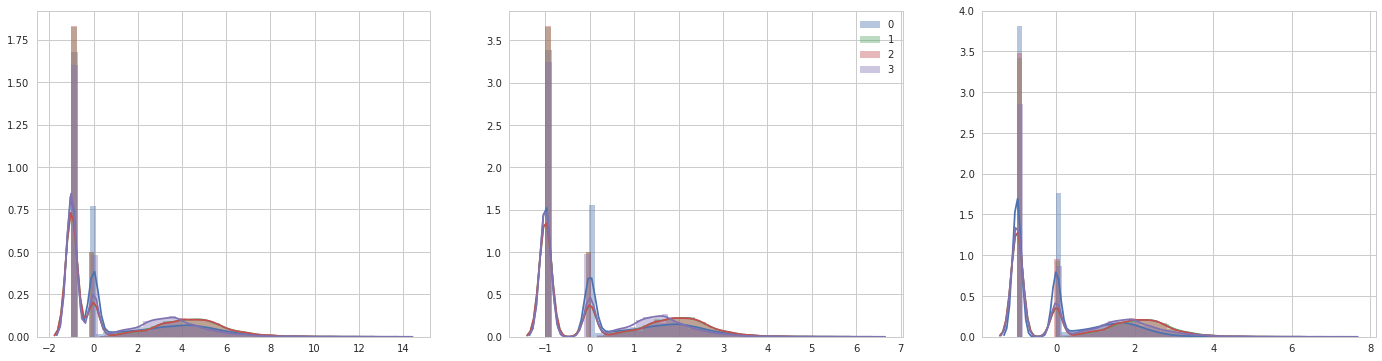

In [32]:
plt.figure(figsize=(24, 6))

X_expr = np.concatenate((X_sc, X_bulk), axis=2)
X_scaled = X_expr.copy()
X_2 = X_expr.copy()

# Unscaled
for i in range(X_expr.shape[2]):
    sns.distplot(X_expr[:,:,i].reshape(-1), label=str(i), ax=plt.subplot(131))

# Each library independently scaled   
for i in range(X_expr.shape[2]):
    X_scaled[:,:,i][X_scaled[:,:,i] > 0] = RobustScaler(with_centering=False).fit_transform(X_scaled[:,:,i][X_scaled[:,:,i] > 0]) 
    sns.distplot(X_scaled[:,:,i].reshape(-1), label=str(i), ax=plt.subplot(133))   
    
# Bulk and SC scaled together
X_2[X_2 > 0] = RobustScaler(with_centering=False).fit_transform(X_2[X_2 > 0])
for i in range(X_expr.shape[2]):
    sns.distplot(X_2[:,:,i].reshape(-1), label=str(i), ax=plt.subplot(132))
    
plt.legend()

### Load the CNV BED files

In [33]:
cn_beds = glob.glob("/srv/shared/vanloo/rna2cn/SRP052901/RRBS/*/bismark/*.bed")
name = lambda k: sample_table.loc[os.path.basename(k).split('_')[0], 'Name'].rsplit('_', 1)[0]
liver_cn = {name(k): fine_bin(pd.read_table(k, header=None).as_matrix(), ws, lambda x,n,y: y) 
            for k in cn_beds}

# Temporary hack: at the centromeres the CN spikes so replace this with -1
for k in liver_cn.keys():
    for i,_ in enumerate(liver_cn[k]):
        liver_cn[k][i][liver_cn[k][i] > 5] = -1
        
Y = np.concatenate([pad_sequences(liver_cn[k], value=-1, padding='post', dtype='float') for k in samples], axis=0)
Y = to_categorical(Y, 7).reshape((*Y.shape, 7))[:,:,:-1]

### Load centromere masks

In [34]:
centromere_bed = pd.read_table("/srv/shared/vanloo/rna2cn/references/centromeres.bed", header=None).as_matrix()
X_centromere = np.array([pad_sequences(fine_bin(centromere_bed, ws, lambda x,n,y: y),value=-1, padding='post')])
X_centromere = np.tile(X_centromere, (1,26,1)).swapaxes(1,2).swapaxes(0,2)

### Calculate GC content track

In [35]:
def chr_gc(chr):
    print("Starting chr"+str(chr))
    genome = Bio.SeqIO.index("/srv/shared/vanloo/rna2cn/references/Homo_sapiens.GRCh38/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa", 'fasta')
    chr_bins = {k: list(zip(np.arange(0, v, ws, dtype=int), np.concatenate([np.arange(ws, v, ws, dtype=int), [v+1]]))) for k, v in seq_dict.items()}
    print("Loaded genome chr"+str(chr))

    gc = np.zeros(len(chr_bins[chr]))
    for i,(s,e) in enumerate(chr_bins[chr]):
        gc[i] = Bio.SeqUtils.GC(genome[chr][s:e].seq)
    print("Done chr"+str(chr))
    return gc

gc_bins = joblib.Parallel(n_jobs=10, verbose=100)(joblib.delayed(chr_gc)(chr) for chr in chromosomes)

Starting chr2
Starting chr3
Starting chr1
Starting chr5
Starting chr4
Starting chr7
Starting chr6
Starting chr9
Starting chr10
Starting chr8
Loaded genome chr6
Loaded genome chr9
Loaded genome chr8
Loaded genome chr4
Loaded genome chr10
Loaded genome chr7
Loaded genome chr1
Loaded genome chr2
Loaded genome chr3
Loaded genome chr5
Done chr10
Pickling array (shape=(134,), dtype=float64).
Starting chr11
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 12.1min
Done chr9
Pickling array (shape=(139,), dtype=float64).
Starting chr12
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed: 12.8min
Loaded genome chr11
Done chr8
Pickling array (shape=(146,), dtype=float64).
Starting chr13
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 13.9min
Loaded genome chr12
Loaded genome chr13
Done chr7
Pickling array (shape=(160,), dtype=float64).
Starting chr14
[Parallel(n_jobs=10)]: Done   4 out of  22 | elapsed: 16.4min remaining: 73.6min
Loaded genome chr14
Done chr6
Pickling array (shape=(171

In [36]:
X_gc = np.array([pad_sequences(gc_bins, value=-1, padding='post', dtype='float')])
X_gc = np.tile(X_gc, (1,26,1)).swapaxes(1,2).swapaxes(0,2)
X_gc = MinMaxScaler().fit_transform(X_gc)

### Concatenate Features into X matrix

In [ ]:
X = np.concatenate((X_expr, X_centromere, X_gc), axis=2)

### Sequence Shortening

According to this article http://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/ training LSTMs struggle with sequences longer than a few hundred time steps due to slow downs vanishing gradients, the solution is to break the input timesteps up (limiting context used in training) and manual control clearing the hidden state.

In [ ]:
len_subseq = 100
n_subseqs = int(X.shape[1]/len_subseq)

paddedX = pad_sequences([x.swapaxes(0,1) for x in np.array_split(X, n_subseqs, axis=1)], value=-2, padding='post', dtype='float').swapaxes(1,2)
X_split = paddedX.reshape(-1, *paddedX.shape[2:], order='F')

paddedY = pad_sequences([x.swapaxes(0,1) for x in np.array_split(Y, n_subseqs, axis=1)], value=-2, padding='post', dtype='float').swapaxes(1,2)
Y_split = paddedY.reshape(-1, *paddedY.shape[2:], order='F')

In [74]:
n_samples = int(X.shape[0]/len(chromosomes))

chr_bins = [np.ones((int(np.ceil(seq_dict[k]/ws)))) for k in chromosomes]
mask2 = pad_sequences(chr_bins, value=0, padding='post', dtype='float').reshape(-1) == 1

mask1 = np.zeros((n_samples, *Y_split.shape[:2]))
for i in range(n_samples):
    mask1[i][i*22*n_subseqs:(i+1)*22*n_subseqs, : ] = (Y_split[i*22*n_subseqs:(i+1)*22*n_subseqs,:,0] != -2)

mask1 = mask1.astype(np.bool)

In [80]:
X_split[X_split == -2] = -1
Y_split[Y_split == -2] = -1

In the split matrices each cell is broken down into chromosomes then padded to the same length.
The padded chromosomes are then split into len_subseq long sequences that are also padded

In [45]:
with open(fout, 'wb') as f:
    pickle.dump([X, Y, mask], f)